Processing real: 100%|██████████| 1997/1997 [00:40<00:00, 49.21it/s]


Epoch 1/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.7793 - loss: 0.4544 - val_accuracy: 0.9485 - val_loss: 0.1350 - learning_rate: 1.0000e-04
Epoch 2/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9565 - loss: 0.1282 - val_accuracy: 0.9732 - val_loss: 0.0739 - learning_rate: 1.0000e-04
Epoch 3/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9741 - loss: 0.0814 - val_accuracy: 0.9860 - val_loss: 0.0485 - learning_rate: 1.0000e-04
Epoch 4/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9809 - loss: 0.0641 - val_accuracy: 0.9841 - val_loss: 0.0468 - learning_rate: 1.0000e-04
Epoch 5/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9838 - loss: 0.0541 - val_accuracy: 0.9866 - val_loss: 0.0383 - learning_rate: 1.0000e-04
Epoch 6/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9852 - loss: 0.0492 - val_accuracy: 0.9891 - val_loss: 0.0368 - learning_rate: 1.0000e-04
Epoch 7/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/ste

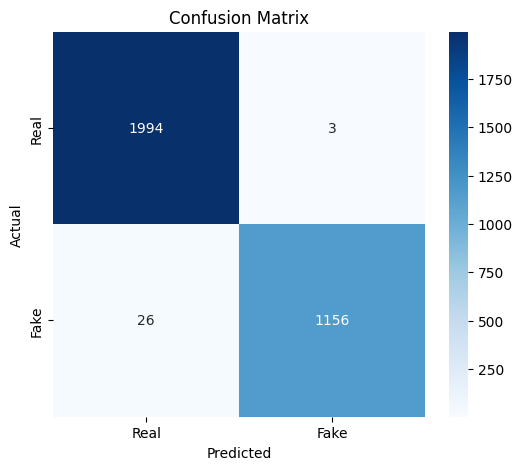

In [1]:
import numpy as np
import librosa
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     GlobalAveragePooling2D, Reshape, Multiply)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Function to extract Mel Spectrogram
def extract_mel_spectrogram(file_path, img_size=(128, 128)):
    y, sr = librosa.load(file_path, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_resized = cv2.resize(mel_spec_db, img_size)
    return mel_spec_resized

# Corrected Paths
data_dir = "/kaggle/input/release-in-the-wild"
train_dir = os.path.join(data_dir, "/kaggle/input/release-in-the-wild/release_in_the_wild/train")
val_dir = os.path.join(data_dir, "/kaggle/input/release-in-the-wild/release_in_the_wild/val")
test_dir = os.path.join(data_dir, "/kaggle/input/release-in-the-wild/release_in_the_wild/test")

# Function to load data
def load_data(directory, img_size=(128, 128)):
    data = []
    labels = []
    classes = {"real": 0, "fake": 1}
    
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file in tqdm(os.listdir(class_dir), desc=f"Processing {label}"):
                file_path = os.path.join(class_dir, file)
                if file_path.endswith(".wav"):
                    mel_spec = extract_mel_spectrogram(file_path, img_size)
                    data.append(mel_spec)
                    labels.append(classes[label])
    
    return np.array(data), np.array(labels)

# Load data
img_size = (128, 128)
X_train, y_train = load_data(train_dir, img_size)
X_val, y_val = load_data(val_dir, img_size)
X_test, y_test = load_data(test_dir, img_size)

# Reshape for CNN
X_train = X_train.reshape(-1, img_size[0], img_size[1], 1)
X_val = X_val.reshape(-1, img_size[0], img_size[1], 1)
X_test = X_test.reshape(-1, img_size[0], img_size[1], 1)

# Normalize
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)

X_train, X_val, X_test = map(normalize, [X_train, X_val, X_test])

# Attention Mechanism
def attention_block(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(inputs.shape[-1], activation='relu')(x)
    x = Dense(inputs.shape[-1], activation='sigmoid')(x)
    x = Reshape((1, 1, inputs.shape[-1]))(x)
    x = Multiply()([inputs, x])
    return x

# Model with attention
def create_model():
    inputs = Input(shape=(128, 128, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = attention_block(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = attention_block(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = attention_block(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

# Train
callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [2]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9855 - loss: 0.0409
Test Accuracy: 99.21%


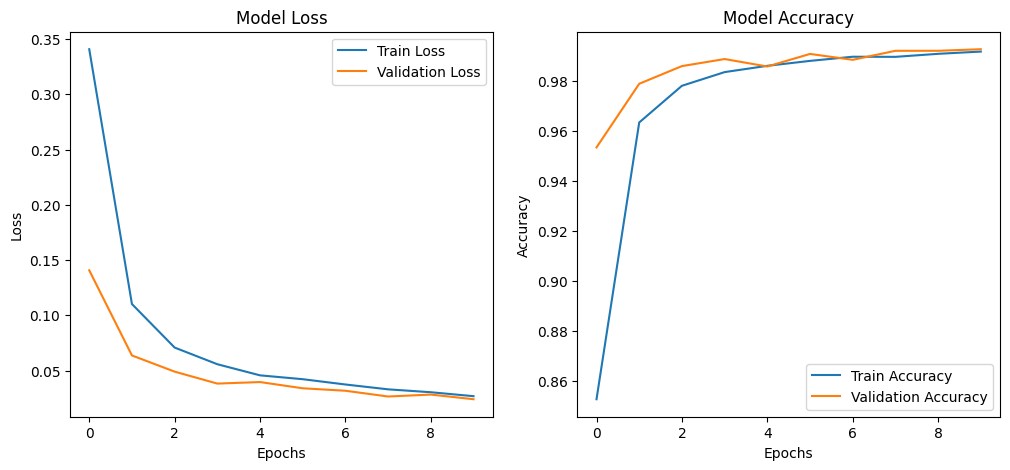

In [3]:
# Plot Model Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.show()

In [23]:
import numpy as np
import librosa
import cv2

# Function to preprocess the test audio file
def preprocess_audio(file_path, img_size=(128, 128)):
    y, sr = librosa.load(file_path, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Resize to match training input size
    mel_spec_resized = cv2.resize(mel_spec_db, img_size)
    
    # Reshape for model input (1 sample, height, width, 1 channel)
    mel_spec_resized = mel_spec_resized.reshape(1, img_size[0], img_size[1], 1)
    
    # Normalize
    mel_spec_resized = (mel_spec_resized - np.min(mel_spec_resized)) / (np.max(mel_spec_resized) - np.min(mel_spec_resized) + 1e-8)
    
    return mel_spec_resized

# Function to predict real or fake (use the model directly after training)
def predict_audio(model, file_path):
    processed_audio = preprocess_audio(file_path)
    prediction = model.predict(processed_audio)[0][0]  # Get probability
    
    if prediction > 0.5:
        print(f"Prediction: 🟥 FAKE ({prediction:.2f})")
    else:
        print(f"Prediction: ✅ REAL ({prediction:.2f})")

# Example usage (after training)
test_audio_path = "/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake/10.wav"  # Change this path
predict_audio(model, test_audio_path)  # Use the trained model directly


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: 🟥 FAKE (1.00)


In [8]:
import numpy as np
import librosa
import cv2
import IPython.display as ipd  # For playing audio

# Function to preprocess the test audio file
def preprocess_audio(file_path, img_size=(128, 128)):
    y, sr = librosa.load(file_path, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Resize to match training input size
    mel_spec_resized = cv2.resize(mel_spec_db, img_size)
    
    # Reshape for model input (1 sample, height, width, 1 channel)
    mel_spec_resized = mel_spec_resized.reshape(1, img_size[0], img_size[1], 1)
    
    # Normalize
    mel_spec_resized = (mel_spec_resized - np.min(mel_spec_resized)) / (np.max(mel_spec_resized) - np.min(mel_spec_resized) + 1e-8)
    
    return mel_spec_resized, y, sr  # Also return audio for playback

# Function to play audio & predict
def predict_audio_with_playback(model, file_path):
    print(f"Playing: {file_path}")
    ipd.display(ipd.Audio(file_path))  # Play the audio

    # Preprocess audio
    processed_audio, y, sr = preprocess_audio(file_path)

    # Predict
    prediction = model.predict(processed_audio)[0][0]

    # Output result
    if prediction > 0.5:
        print(f"Prediction: 🟥 FAKE ({prediction:.2f})")
    else:
        print(f"Prediction: ✅ REAL ({prediction:.2f})")

# Example usage
test_audio_path = "/kaggle/input/release-in-the-wild/release_in_the_wild/test/real/10098.wav"  # Change path
predict_audio_with_playback(model, test_audio_path)


Playing: /kaggle/input/release-in-the-wild/release_in_the_wild/test/real/10098.wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: ✅ REAL (0.00)
